# Neuralink Time Series Forecasting


## Imports


In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from glob import glob
import scipy.io
import IPython

## Configure Tensorflow


In [3]:
# Identify if the GPU is detected
# tf.config.list_physical_devices()

# Identify if the GPU is being used.
# tf.debugging.set_log_device_placement(False)

## Import Data


In [4]:
data_dir = "../../data/"
data_file_l = glob(data_dir + "*.wav")

In [5]:
rate, data = scipy.io.wavfile.read(data_file_l[0])

In [6]:
data_df = pd.DataFrame(data, columns=["Amplitude"])

In [7]:
time = np.arange(0, len(data_df) / rate, (1 / rate))

In [8]:
time

array([0.00000000e+00, 5.12006554e-05, 1.02401311e-04, ...,
       5.05329988e+00, 5.05335108e+00, 5.05340228e+00])

In [9]:
data_df.insert(loc=1, column="Time", value=time, allow_duplicates=True)

In [10]:
data_df = data_df.reindex(columns=["Time", "Amplitude"])

In [11]:
data_df.index.name = "Sample Number"

<Axes: title={'center': 'Raw Neural Signal'}, xlabel='Time [s]'>

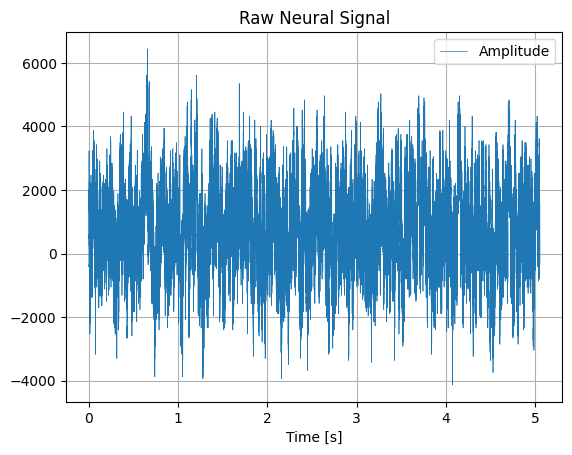

In [12]:
data_df.plot(
    xlabel="Time [s]", x="Time", grid=True, linewidth=0.5, title="Raw Neural Signal"
)

In [13]:
data_df.__len__()

98699

In [14]:
df = data_df.drop("Time", axis=1)

In [15]:
n = df.__len__()

## Defining Training, Validation, & Test Sets


In [80]:
column_indices = {name: i for i, name in enumerate(df.columns)}

train_df = df[0 : int(n * 0.7)]
val_df = df[int(n * 0.7) : int(n * 0.9)]
test_df = df[int(n * 0.9) :]

num_features = df.shape[1]

In [17]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

/var/folders/km/lr9wgyjj0z737tmwxblc5d980000gn/T/ipykernel_31358/2004759091.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


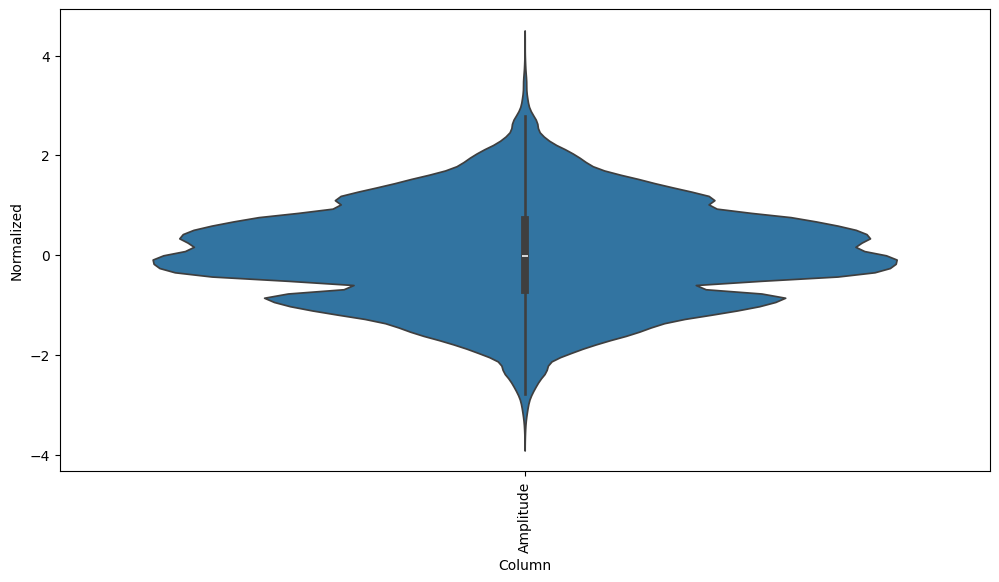

In [18]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name="Column", value_name="Normalized")
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [19]:
class WindowGenerator:
    def __init__(
        self,
        input_width,
        label_width,
        shift,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        label_columns=None,
    ):
        # Store the raw data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )

In [20]:
w1 = WindowGenerator(
    input_width=24, label_width=1, shift=24, label_columns=["Amplitude"]
)

In [21]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=["Amplitude"])

In [22]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1,
        )

    # Slicing doesn't preserve static shape information, so set the shapes manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels


WindowGenerator.split_window = split_window

In [23]:
# Stack three slices, the length of the total window.
example_window = tf.stack(
    [
        np.array(train_df[: w2.total_window_size]),
        np.array(train_df[100 : 100 + w2.total_window_size]),
        np.array(train_df[200 : 200 + w2.total_window_size]),
    ]
)

example_inputs, example_labels = w2.split_window(example_window)

print("All shapes are: (batch, time, features)")
print(f"Window shape: {example_window.shape}")
print(f"Inputs shape: {example_inputs.shape}")
print(f"Labels shape: {example_labels.shape}")

All shapes are: (batch, time, features)
Window shape: (3, 7, 1)
Inputs shape: (3, 6, 1)
Labels shape: (3, 1, 1)


2024-09-04 10:28:46.788303: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-09-04 10:28:46.788322: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-09-04 10:28:46.788327: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-09-04 10:28:46.788341: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-04 10:28:46.788351: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [24]:
w2.example = example_inputs, example_labels

In [25]:
def plot(self, model=None, plot_col="Amplitude", max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n + 1)
        plt.ylabel(f"{plot_col} [normed]")
        plt.plot(
            self.input_indices,
            inputs[n, :, plot_col_index],
            label="Inputs",
            marker=".",
            zorder=-10,
        )

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(
            self.label_indices,
            labels[n, :, label_col_index],
            edgecolors="k",
            label="Labels",
            c="#2ca02c",
            s=64,
        )
        if model is not None:
            predictions = model(inputs)
            plt.scatter(
                self.label_indices,
                predictions[n, :, label_col_index],
                marker="X",
                edgecolors="k",
                label="Predictions",
                c="#ff7f0e",
                s=64,
            )

        if n == 0:
            plt.legend()

    plt.xlabel("Time [h]")


WindowGenerator.plot = plot

In [26]:
w2.label_columns_indices

{'Amplitude': 0}

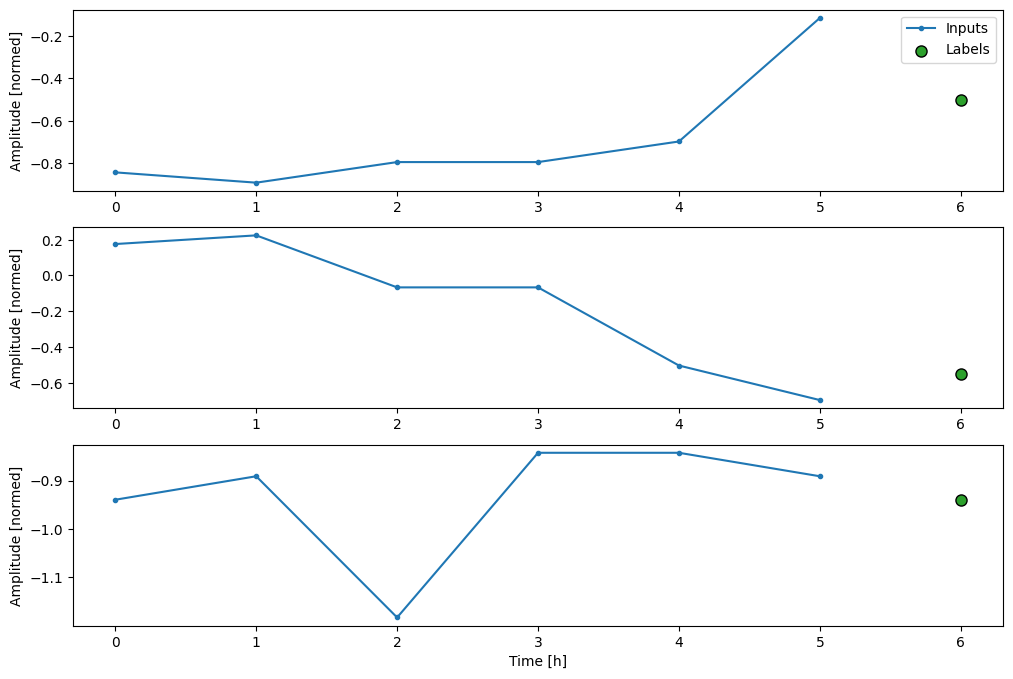

In [27]:
w2.plot()

In [28]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,
    )
    ds = ds.map(self.split_window)

    return ds


WindowGenerator.make_dataset = make_dataset

In [29]:
@property
def train(self):
    return self.make_dataset(self.train_df)


@property
def val(self):
    return self.make_dataset(self.val_df)


@property
def test(self):
    return self.make_dataset(self.test_df)


@property
def example(self):
    """get and cache an example batch of `inputs, labels` for ploting."""
    result = getattr(self, "_example", None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result


WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [30]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [31]:
for example_inputs, example_labels in w2.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

Inputs shape (batch, time, features): (32, 6, 1)
Labels shape (batch, time, features): (32, 1, 1)


2024-09-04 10:28:47.479069: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Single Step Model


In [32]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=["Amplitude"]
)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Amplitude']

In [33]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


2024-09-04 10:28:47.545301: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Baseline


In [34]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [35]:
baseline = Baseline(label_index=column_indices["Amplitude"])

baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

val_performance = {}
performance = {}
val_performance["Baseline"] = baseline.evaluate(
    single_step_window.val, return_dict=True
)
performance["Baseline"] = baseline.evaluate(
    single_step_window.test, verbose=0, return_dict=True
)

2024-09-04 10:28:47.632806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0881 - mean_absolute_error: 0.2345


In [36]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1, label_columns=["Amplitude"]
)
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Amplitude']

In [37]:
print("Input shape:", wide_window.example[0].shape)
print("Output shape:", baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


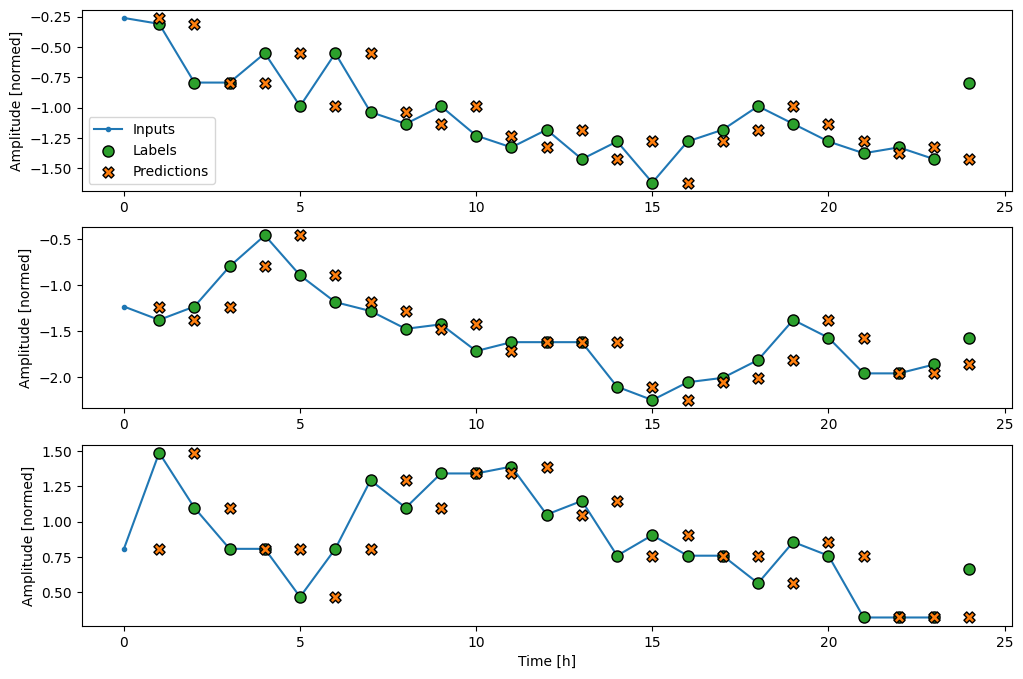

In [38]:
wide_window.plot(baseline)

### Linear Model


In [39]:
linear = tf.keras.Sequential([tf.keras.layers.Dense(units=1)])

In [40]:
print("Input shape:", single_step_window.example[0].shape)
print("Output shape:", linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 1)
Output shape: (32, 1, 1)


In [41]:
MAX_EPOCHS = 20


def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, mode="min"
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )

    history = model.fit(
        window.train,
        epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping],
    )
    return history

In [42]:
history = compile_and_fit(linear, single_step_window)

val_performance["Linear"] = linear.evaluate(single_step_window.val, return_dict=True)
performance["Linear"] = linear.evaluate(
    single_step_window.test, verbose=0, return_dict=True
)

Epoch 1/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 3.4376 - mean_absolute_error: 1.4424 - val_loss: 0.4847 - val_mean_absolute_error: 0.5525
Epoch 2/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.2827 - mean_absolute_error: 0.4112 - val_loss: 0.0873 - val_mean_absolute_error: 0.2349
Epoch 3/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0869 - mean_absolute_error: 0.2342 - val_loss: 0.0865 - val_mean_absolute_error: 0.2336
Epoch 4/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0867 - mean_absolute_error: 0.2338 - val_loss: 0.0865 - val_mean_absolute_error: 0.2336
Epoch 5/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0867 - mean_absolute_error: 0.2338 - val_loss: 0.0865 - val_mean_absolute_error: 0.2336
Epoch 6/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 0.0868 - mean_absolute_error: 0.2339 - val_loss: 0.0865 - val_mean_absolute_error: 0.2336
617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0870 - mean_absolute_error: 0.2

In [43]:
print("Input shape:", wide_window.example[0].shape)
print("Output shape:", wide_window.example[0].shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


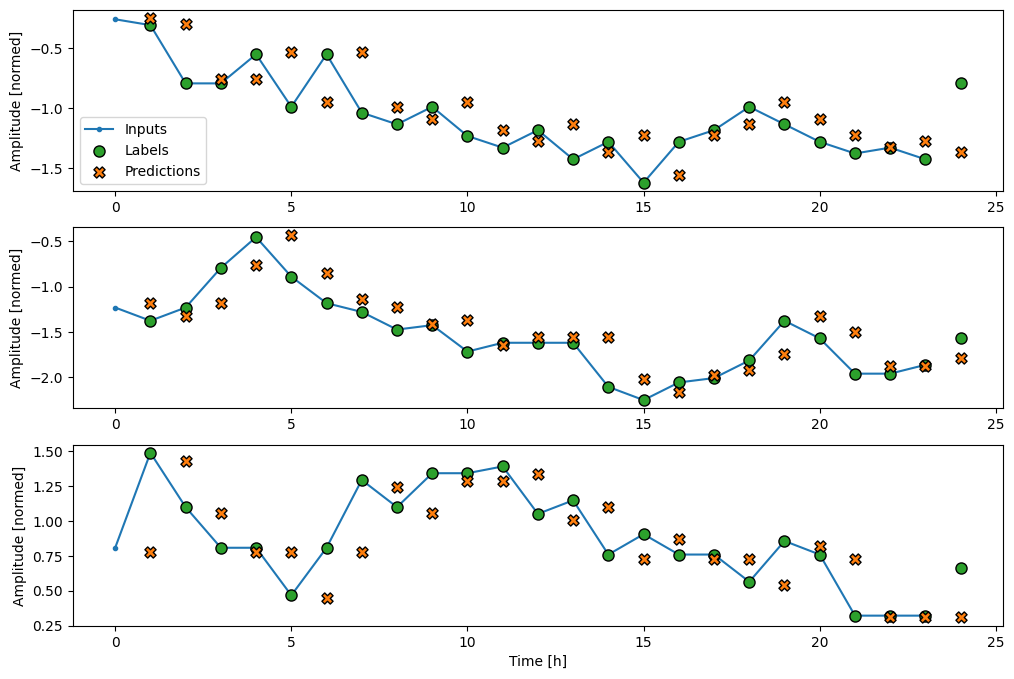

In [44]:
wide_window.plot(linear)

In [45]:
linear.layers[0].kernel[:, 0].numpy()

array([0.95837325], dtype=float32)

In [46]:
linear.save("linear_model.keras")

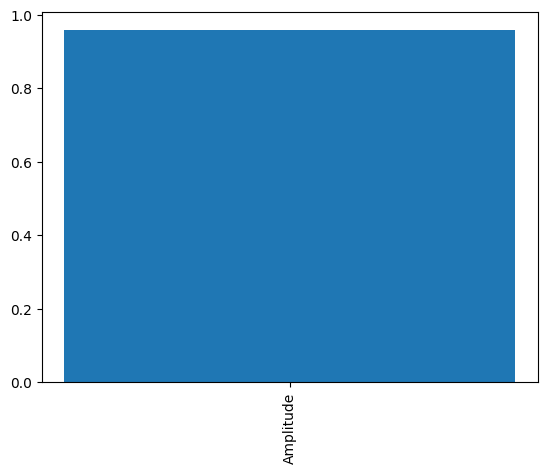

In [47]:
# Visualizing the model's weights assigned to each input

plt.bar(x=range(len(train_df.columns)), height=linear.layers[0].kernel[:, 0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

### Dense


In [48]:
dense = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=1),
    ]
)

history = compile_and_fit(dense, single_step_window)

val_performance["Dense"] = dense.evaluate(single_step_window.val, return_dict=True)
performance["Dense"] = dense.evaluate(
    single_step_window.test, verbose=0, return_dict=True
)

Epoch 1/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.1255 - mean_absolute_error: 0.2616 - val_loss: 0.0870 - val_mean_absolute_error: 0.2346
Epoch 2/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.0882 - mean_absolute_error: 0.2361 - val_loss: 0.0879 - val_mean_absolute_error: 0.2361
Epoch 3/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - loss: 0.0880 - mean_absolute_error: 0.2361 - val_loss: 0.0866 - val_mean_absolute_error: 0.2344
Epoch 4/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0881 - mean_absolute_error: 0.2363 - val_loss: 0.0870 - val_mean_absolute_error: 0.2349
Epoch 5/20
2159/2159 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0878 - mean_absolute_error: 0.2360 - val_loss: 0.0877 - val_mean_absolute_error: 0.2360
617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0881 - mean_absolute_error: 0.2371


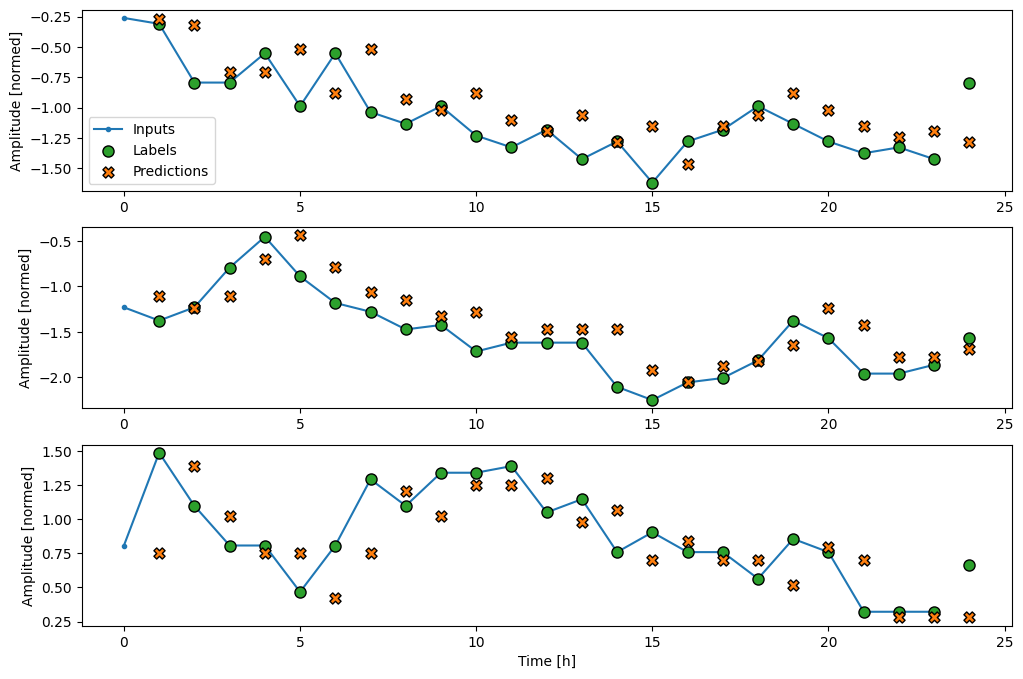

In [49]:
wide_window.plot(dense)

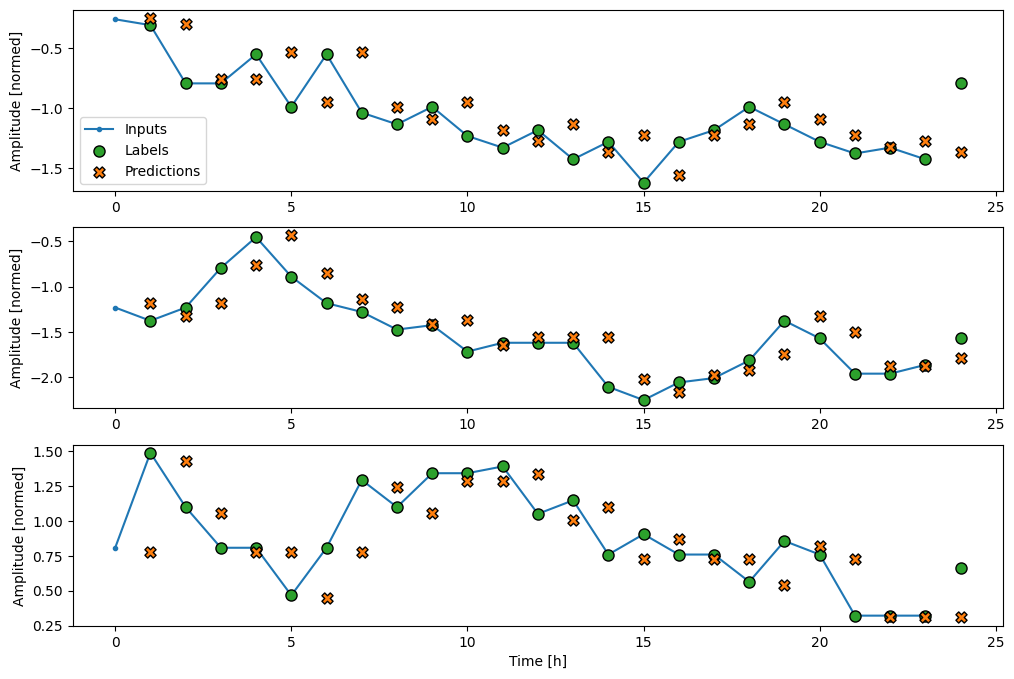

In [50]:
wide_window.plot(linear)

### Multi-step dense


In [51]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH, label_width=1, shift=1, label_columns=["Amplitude"]
)
conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Amplitude']

Text(0.5, 0.98, 'Given 3 hours of inputs, predict 1 hour into the future.')

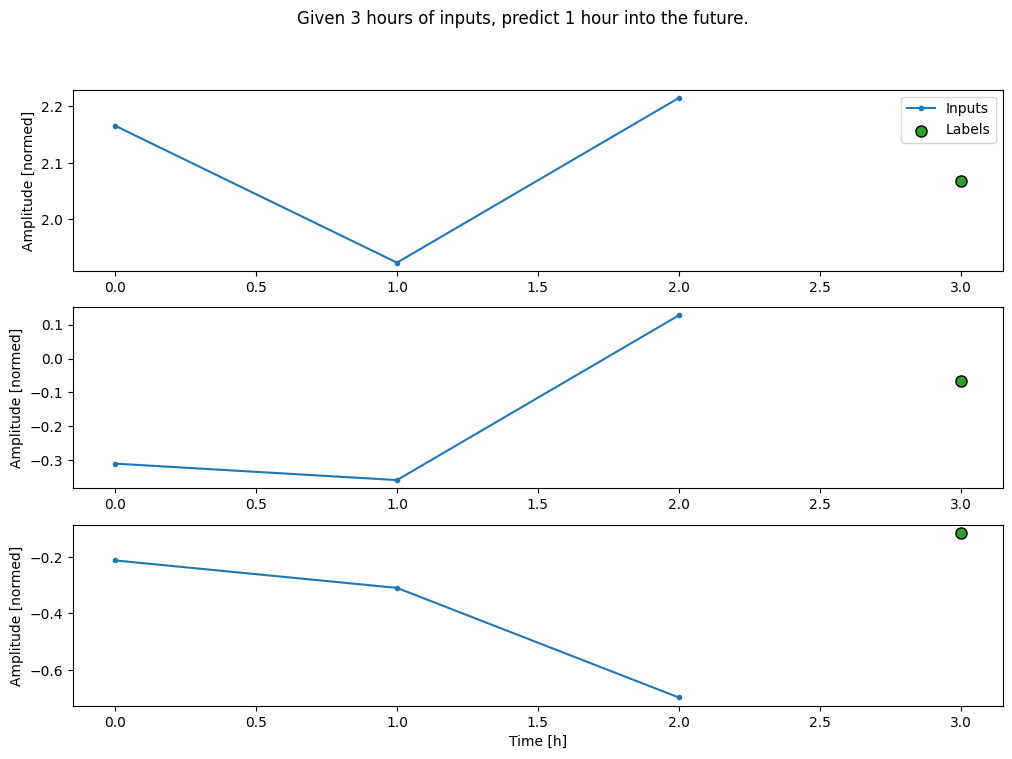

In [52]:
conv_window.plot()
plt.suptitle("Given 3 hours of inputs, predict 1 hour into the future.")

In [53]:
multi_step_dense = tf.keras.Sequential(
    [
        # Shape: (time, features) => (time*features)
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=32, activation="relu"),
        tf.keras.layers.Dense(units=32, activation="relu"),
        tf.keras.layers.Dense(units=1),
        # Add back the time dimension.
        # Shape: (outputs) => (1, outputs)
        tf.keras.layers.Reshape([1, -1]),
    ]
)

In [54]:
print("Input shape:", conv_window.example[0].shape)
print("Output shape:", multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 1)
Output shape: (32, 1, 1)


In [55]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance["Multi step dense"] = multi_step_dense.evaluate(
    conv_window.val, return_dict=True
)
performance["Multi step dense"] = multi_step_dense.evaluate(
    conv_window.test, verbose=0, return_dict=True
)

617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0868 - mean_absolute_error: 0.2343


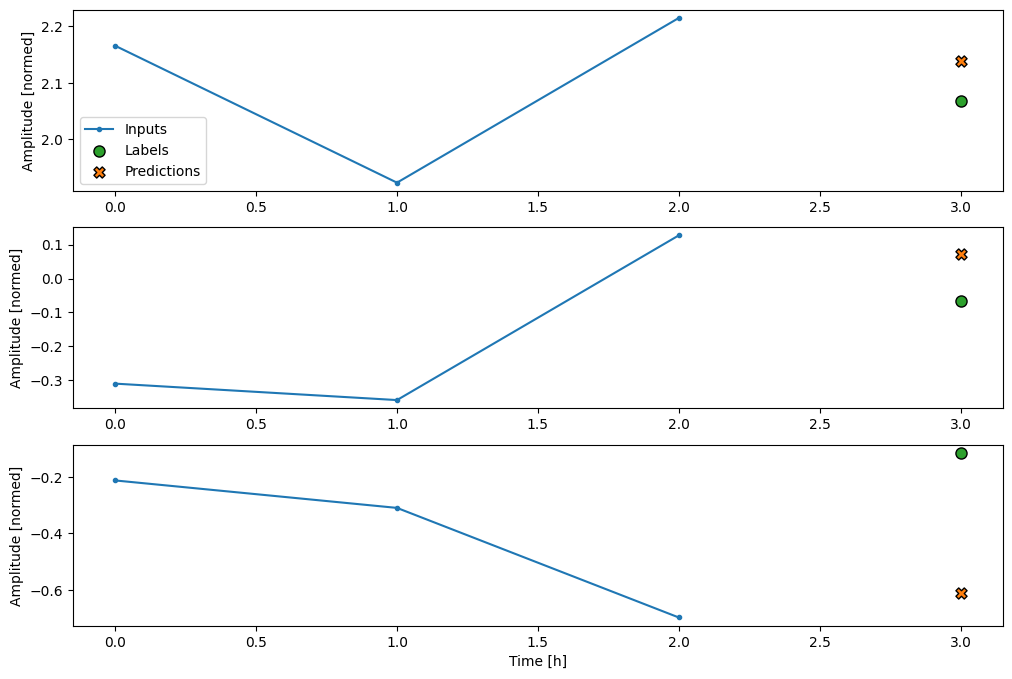

In [56]:
conv_window.plot(multi_step_dense)

In [57]:
# This method is only compatible with inputs of a specific shape.

print("Input shape:", wide_window.example[0].shape)
try:
    print("Output shape:", multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f"\n{type(e).__name__}:{e}")

Input shape: (32, 24, 1)

ValueError:Exception encountered when calling Sequential.call().

Input 0 of layer "dense_4" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (32, 24)

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 24, 1), dtype=float32)
  • training=None
  • mask=None


### Convolutional Neural Network


In [58]:
conv_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(
            filters=32, kernel_size=(CONV_WIDTH,), activation="relu"
        ),
        tf.keras.layers.Dense(units=32, activation="relu"),
        tf.keras.layers.Dense(units=1),
    ]
)

In [59]:
print("Conv model on `conv_window`")
print("Input shape:", conv_window.example[0].shape)
print("Output shape:", conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 1)
Output shape: (32, 1, 1)


In [60]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance["Conv"] = conv_model.evaluate(conv_window.val, return_dict=True)
performance["Conv"] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)

617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0876 - mean_absolute_error: 0.2357


In [61]:
print("Wide window")
print("Input shape:", wide_window.example[0].shape)
print("Labels shape:", wide_window.example[1].shape)
print("Output shape:", conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 1)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [62]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=["Amplitude"],
)

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Amplitude']

In [63]:
print("Wide conv window")
print("Input shape:", wide_conv_window.example[0].shape)
print("Labels shape:", wide_conv_window.example[1].shape)
print("Output shape:", conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 1)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


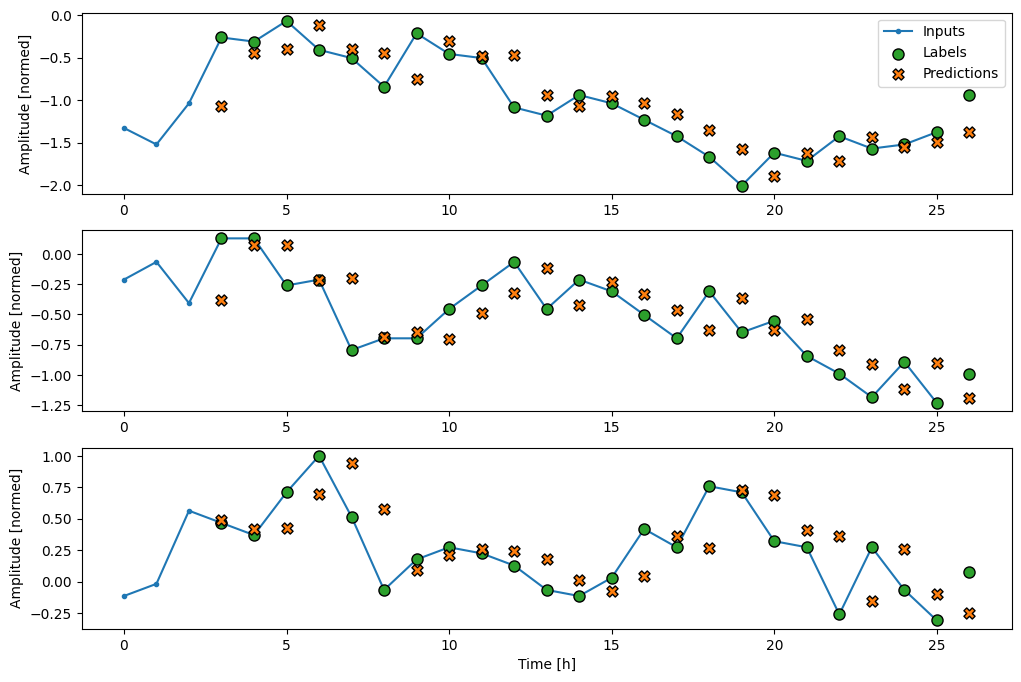

In [64]:
wide_conv_window.plot(conv_model)

### Recurrent Neural Network


In [65]:
lstm_model = tf.keras.models.Sequential(
    [
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(32, return_sequences=True),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1),
    ]
)

In [66]:
print("Input shape:", wide_window.example[0].shape)
print("Output shape:", lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 1)
Output shape: (32, 24, 1)


In [67]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance["LSTM"] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance["LSTM"] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0838 - mean_absolute_error: 0.2304


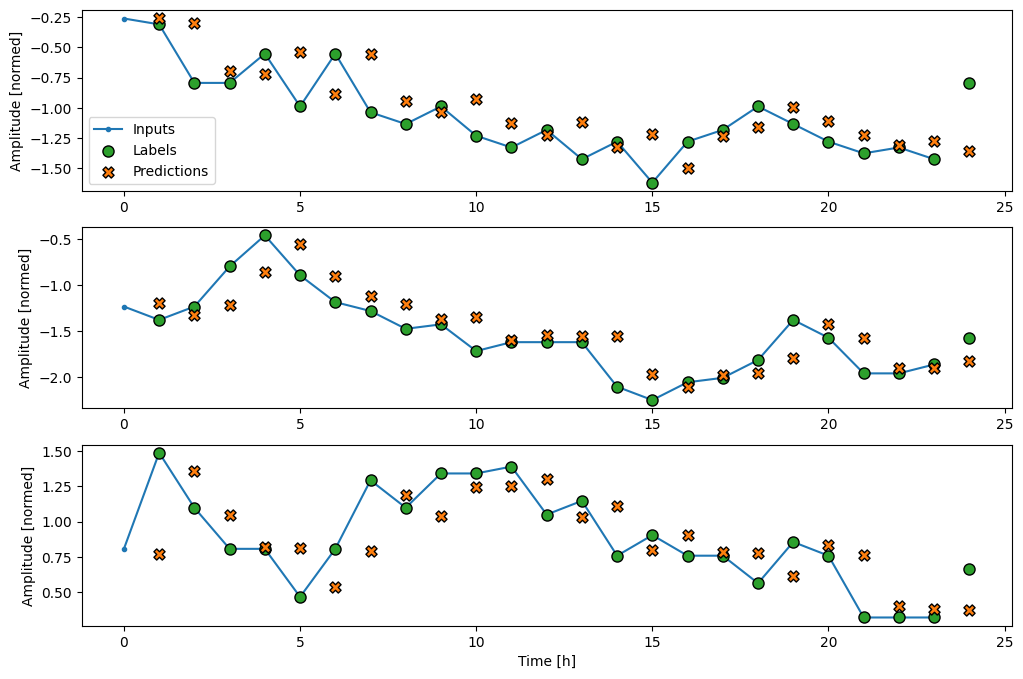

In [69]:
wide_window.plot(lstm_model)

### Performance


In [70]:
cm = lstm_model.metrics[1]
cm.metrics

[<MeanAbsoluteError name=mean_absolute_error>]

In [71]:
val_performance

{'Baseline': {'loss': 0.08846591413021088,
  'mean_absolute_error': 0.23533053696155548},
 'Linear': {'loss': 0.08652380853891373,
  'mean_absolute_error': 0.2335883378982544},
 'Dense': {'loss': 0.08765386044979095,
  'mean_absolute_error': 0.23598821461200714},
 'Multi step dense': {'loss': 0.08524909615516663,
  'mean_absolute_error': 0.2322017401456833},
 'Conv': {'loss': 0.08748829364776611,
  'mean_absolute_error': 0.23528511822223663},
 'LSTM': {'loss': 0.08376704901456833,
  'mean_absolute_error': 0.2301446944475174}}

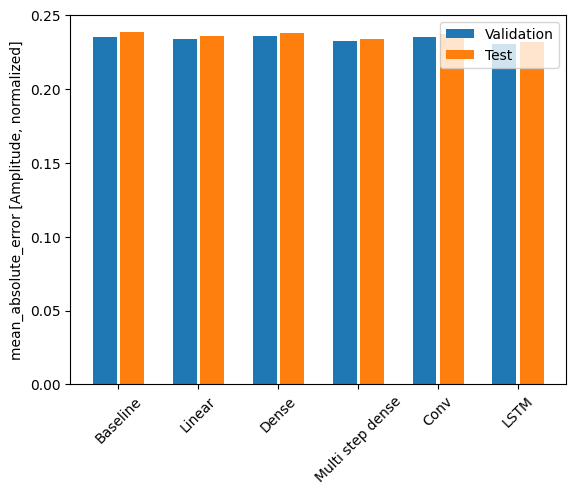

In [73]:
x = np.arange(len(performance))
width = 0.3
metric_name = "mean_absolute_error"
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel("mean_absolute_error [Amplitude, normalized]")
plt.bar(x - 0.17, val_mae, width, label="Validation")
plt.bar(x + 0.17, test_mae, width, label="Test")
plt.xticks(ticks=x, labels=performance.keys(), rotation=45)
_ = plt.legend()

In [74]:
for name, value in performance.items():
    print(f"{name:12s}: {value[metric_name]:0.4f}")

Baseline    : 0.2383
Linear      : 0.2361
Dense       : 0.2381
Multi step dense: 0.2341
Conv        : 0.2373
LSTM        : 0.2321


### Multi-output models


In [75]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you
    # don't set the `label_columns` argument.
    input_width=1,
    label_width=1,
    shift=1,
)

wide_window = WindowGenerator(input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f"Inputs shape (batch, time, features): {example_inputs.shape}")
    print(f"Labels shape (batch, time, features): {example_labels.shape}")

Inputs shape (batch, time, features): (32, 24, 1)
Labels shape (batch, time, features): (32, 24, 1)


#### Baseline


In [76]:
baseline = Baseline()
baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

In [77]:
val_performance = {}
performance = {}
val_performance["Baseline"] = baseline.evaluate(wide_window.val, return_dict=True)
performance["Baseline"] = baseline.evaluate(
    wide_window.test, verbose=0, return_dict=True
)

617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0884 - mean_absolute_error: 0.2352


#### Dense


In [83]:
dense = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=64, activation="relu"),
        tf.keras.layers.Dense(units=num_features),
    ]
)

#### RNN


In [86]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1
)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

print()

617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0864 - mean_absolute_error: 0.2335

CPU times: user 1min 27s, sys: 50.6 s, total: 2min 17s
Wall time: 56.1 s


#### Advanced Residual Connections


In [88]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each time step is the input
        # from the previous time step plut the delta
        # calculated by the model.
        return inputs + delta

In [89]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.Dense(
            num_features, 
            # The predicted deltas should start small.
            # Therefore, initialize the output layer with zeros.
            kernel_initializer=tf.initializers.zeros()
        )
    ]
    )
)

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0, return_dict=True)
print()

Epoch 1/20
